<a href="https://colab.research.google.com/github/alekya-narne/BVRITHYDERABAD/blob/main/5m_Dead_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Loading Data**

In [1]:
!pip install -q kaggle
!pip install -q feature_engine
!pip install shap
!pip install catboost
!pip install lime
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=8b498a31ad92b2419eb3668862b1a6761ed284bc6daef355c1f8d6ab5b8fa739
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=cd0b1bd211bef917487c8f3a542ffe89eb93f1d24e8322a7bebe05c2c832d72c
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekyanarne","key":"2dbf637ef2510d78df6ad8f1039194cf"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d 'mexwell/5m-trees-dataset'

 98% 116M/118M [00:02<00:00, 99.5MB/s]
100% 118M/118M [00:02<00:00, 57.0MB/s]


In [7]:
! mkdir kaggle_data
! unzip 5m-trees-dataset.zip -d kaggle_data

Archive:  5m-trees-dataset.zip
  inflating: kaggle_data/Albuquerque_Final_2022-06-18.csv  
  inflating: kaggle_data/Anaheim_Final_2022-06-18.csv  
  inflating: kaggle_data/Arlington_Final_2022-06-18.csv  
  inflating: kaggle_data/Atlanta_Final_2022-06-18.csv  
  inflating: kaggle_data/AuroraCO_Final_2022-06-18.csv  
  inflating: kaggle_data/Austin_Final_2022-06-18.csv  
  inflating: kaggle_data/Baltimore_Final_2022-06-18.csv  
  inflating: kaggle_data/Boston_Final_2022-06-18.csv  
  inflating: kaggle_data/Buffalo_Final_2022-06-18.csv  
  inflating: kaggle_data/CapeCoral_Final_2022-06-18.csv  
  inflating: kaggle_data/ColoradoSprings_Final_2022-06-18.csv  
  inflating: kaggle_data/Columbus_Final_2022-06-18.csv  
  inflating: kaggle_data/Column_Headers_Dryad.csv  
  inflating: kaggle_data/Dallas_Final_2022-06-18.csv  
  inflating: kaggle_data/Denver_Final_2022-06-18.csv  
  inflating: kaggle_data/DesMoines_Final_2022-06-18.csv  
  inflating: kaggle_data/Detroit_Final_2022-06-18.csv  
  i

In [8]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from feature_engine.encoding import RareLabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools

import lime
from lime import lime_tabular

pd.set_option('display.max_rows', 1000)

In [9]:
%%time
df_list = []
import os
for dirname, _, filenames in os.walk('/content/kaggle_data'):
    for filename in filenames:
        file = os.path.join(dirname, filename)
        if file.endswith('.csv'):
            print(file)
            df_tmp = pd.read_csv(file)
            df_list.append(df_tmp)
df = pd.concat(df_list, axis=0).drop_duplicates()
print(df.shape)
df.sample(5).T

/content/kaggle_data/OklahomaCity_Final_2022-06-18.csv
/content/kaggle_data/Arlington_Final_2022-06-18.csv
/content/kaggle_data/Dallas_Final_2022-06-18.csv
/content/kaggle_data/Phoenix_Final_2022-06-18.csv
/content/kaggle_data/Atlanta_Final_2022-06-18.csv
/content/kaggle_data/Tampa_Final_2022-06-18.csv
/content/kaggle_data/Madison_Final_2022-06-18.csv
/content/kaggle_data/SiouxFalls_Final_2022-06-18.csv
/content/kaggle_data/Columbus_Final_2022-06-18.csv
/content/kaggle_data/HuntingtonBeach_Final_2022-06-18.csv
/content/kaggle_data/Miami_Final_2022-06-18.csv
/content/kaggle_data/AuroraCO_Final_2022-06-18.csv
/content/kaggle_data/Durham_Final_2022-06-18.csv
/content/kaggle_data/Milwaukee_Final_2022-06-18.csv
/content/kaggle_data/RanchoCucamonga_Final_2022-06-18.csv
/content/kaggle_data/Baltimore_Final_2022-06-18.csv
/content/kaggle_data/Irvine_Final_2022-06-18.csv
/content/kaggle_data/DesMoines_Final_2022-06-18.csv
/content/kaggle_data/Detroit_Final_2022-06-18.csv
/content/kaggle_data/De

,96779,72211,62031,21331,1372
most_recent_observation,06/04/2018,04/25/2018,NaN,2020/08/12 20:41:53+00,NaN
most_recent_observation_type,NaN,NaN,NaN,NaN,NaN
common_name,Callery pear,Callery pear,Chinese pistache,NaN,Japanese zelkova
scientific_name,Pyrus calleryana,Pyrus calleryana,Pistacia chinensis,Quercus ilex,Zelkova serrata
city,Baltimore,Baltimore,Stockton,San Jose,Pittsburgh
state,Maryland,Maryland,California,California,Pennsylvania
longitude_coordinate,-76.616967,-76.599667,-121.344086,-121.869771,-79.970432
latitude_coordinate,39.324547,39.301595,38.055444,37.384066,40.426678
location_name,NaN,NaN,NaN,NaN,NaN
diameter_breast_height_CM,36.068,31.75,NaN,38.1,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998213 entries, 0 to 2047
Data columns (total 30 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   most_recent_observation           object 
 1   most_recent_observation_type      object 
 2   common_name                       object 
 3   scientific_name                   object 
 4   city                              object 
 5   state                             object 
 6   longitude_coordinate              float64
 7   latitude_coordinate               float64
 8   location_name                     object 
 9   diameter_breast_height_CM         float64
 10  height_M                          float64
 11  native                            object 
 12  height_binned_M                   object 
 13  diameter_breast_height_binned_CM  object 
 14  greater_metro                     object 
 15  city_ID                           object 
 16  tree_ID                           float

In [11]:
df['condition'].value_counts()

good          1536131
fair           688117
poor           142226
excellent      105794
dead            30587
dead/dying      20479
                16675
Name: condition, dtype: int64

# **Data Transformation**

In [12]:
%%time
main_label = 'condition'
df = df[df[main_label].isin(['good', 'fair', 'poor', 'excellent', 'dead', 'dead/dying'])]
df[main_label] = (df[main_label].isin(['dead', 'dead/dying'])).astype(int)
df['city'] = df['city'] + ', ' + df['state']
for col in ['most_recent_observation_type', 'scientific_name', 'city', 'native', 'height_binned_M',
            'diameter_breast_height_binned_CM', 'location_type', 'overhead_utility']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=70, replace_with='Other', tol=400/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
cols2drop = ['common_name', 'longitude_coordinate', 'latitude_coordinate', 'location_name', 'diameter_breast_height_CM',
             'height_M', 'greater_metro', 'city_ID', 'tree_ID', 'planted_date', 'retired_date', 'zipcode', 'address',
             'neighborhood', 'ward', 'district', 'percent_population', 'column_name', 'definition', 'state',
             'most_recent_observation']
df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(2523334, 9)
CPU times: user 18.9 s, sys: 5.08 s, total: 24 s
Wall time: 24.2 s


,408391,870,509902,313016,16451
most_recent_observation_type,inventory_date,None,inventory_date,None,None
scientific_name,Other,Gleditsia triacanthos,Tilia cordata,Pistacia chinensis,Lagerstroemia indica
city,"Los Angeles, California","Minneapolis, Minnesota","New York, New York","San Jose, California","Rancho Cucamonga, California"
native,no_info,naturally_occurring,introduced,introduced,introduced
height_binned_M,None,None,None,more than 18.29 m,None
diameter_breast_height_binned_CM,30.48 to 45.72 cm,30.48 to 45.72 cm,30.48 to 45.72 cm,0 to 15.24 cm,None
location_type,None,built_environment,no_info,None,None
overhead_utility,None,No,None,None,None
condition,0,0,0,0,0


In [42]:
df['condition'].value_counts()

0    2472268
1      51066
Name: condition, dtype: int64

In [14]:
df

,most_recent_observation_type,scientific_name,city,native,height_binned_M,diameter_breast_height_binned_CM,location_type,overhead_utility,condition
0,None,Quercus macrocarpa,"Sioux Falls, South Dakota",naturally_occurring,more than 18.29 m,0 to 15.24 cm,green_space,None,0
1,None,Cercis canadensis,"Sioux Falls, South Dakota",introduced,more than 18.29 m,0 to 15.24 cm,green_space,None,0
3,None,Cercis canadensis,"Sioux Falls, South Dakota",introduced,more than 18.29 m,0 to 15.24 cm,green_space,None,0
7,None,Cercis canadensis,"Sioux Falls, South Dakota",introduced,more than 18.29 m,0 to 15.24 cm,green_space,None,0
8,None,Other,"Sioux Falls, South Dakota",introduced,more than 18.29 m,0 to 15.24 cm,green_space,None,0
...,...,...,...,...,...,...,...,...,...
9995,None,Pistacia chinensis,"Knoxville, Tennessee",introduced,None,0 to 15.24 cm,built_environment,No,0
9996,None,Lagerstroemia indica,"Knoxville, Tennessee",introduced,None,0 to 15.24 cm,built_environment,No,0
9997,None,Lagerstroemia indica,"Knoxville, Tennessee",introduced,None,0 to 15.24 cm,built_environment,No,0
9998,None,Prunus virginiana,"Knoxville, Tennessee",naturally_occurring,None,0 to 15.24 cm,built_environment,No,0


# **Machine Learning**

In [15]:
%%time
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

CPU times: user 1.69 s, sys: 134 ms, total: 1.82 s
Wall time: 1.83 s


((2018667, 8), (504667, 8), (2018667,), (504667,))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
# add class weights to handle imbalanced classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)

{0: 0.5103278164680805, 1: 24.70647198492155}


In [17]:
%%time
# initialize Pool
train_pool = Pool(X_train,
                  y_train,
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters
model = CatBoostClassifier(iterations=170,
                           depth=5,
                           border_count=20,
                           l2_leaf_reg=0.4,
                           learning_rate=4e-1,
                           class_weights=class_weights,
                           verbose=1)

#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict_proba(train_pool)[:,1]
y_test_pred = model.predict_proba(test_pool)[:,1]
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC score for train {round(roc_auc_train,4)}, and for test {round(roc_auc_test,4)}")

0:	learn: 0.5913291	total: 1.03s	remaining: 2m 54s
1:	learn: 0.5126396	total: 1.68s	remaining: 2m 20s
2:	learn: 0.4766043	total: 2.36s	remaining: 2m 11s
3:	learn: 0.4419338	total: 3.5s	remaining: 2m 25s
4:	learn: 0.4226604	total: 4.38s	remaining: 2m 24s
5:	learn: 0.4044039	total: 5.41s	remaining: 2m 27s
6:	learn: 0.3947671	total: 6.44s	remaining: 2m 29s
7:	learn: 0.3885237	total: 7.1s	remaining: 2m 23s
8:	learn: 0.3818838	total: 7.7s	remaining: 2m 17s
9:	learn: 0.3777223	total: 8.31s	remaining: 2m 12s
10:	learn: 0.3736703	total: 8.95s	remaining: 2m 9s
11:	learn: 0.3701149	total: 9.56s	remaining: 2m 5s
12:	learn: 0.3652227	total: 10.2s	remaining: 2m 3s
13:	learn: 0.3634149	total: 10.8s	remaining: 2m
14:	learn: 0.3611469	total: 11.4s	remaining: 1m 57s
15:	learn: 0.3588761	total: 12s	remaining: 1m 55s
16:	learn: 0.3571020	total: 12.6s	remaining: 1m 53s
17:	learn: 0.3538139	total: 13.3s	remaining: 1m 51s
18:	learn: 0.3525534	total: 13.9s	remaining: 1m 50s
19:	learn: 0.3515777	total: 14.4s	

In [18]:
# calculating the baseline ROC AUC score assuming the same probability from training labels to test
roc_auc_baseline = roc_auc_score(y_test, [np.mean(y_train)]*len(y_test))
print(roc_auc_baseline)

0.5


Accuracy: 0.8199
F1 Score: 0.1556


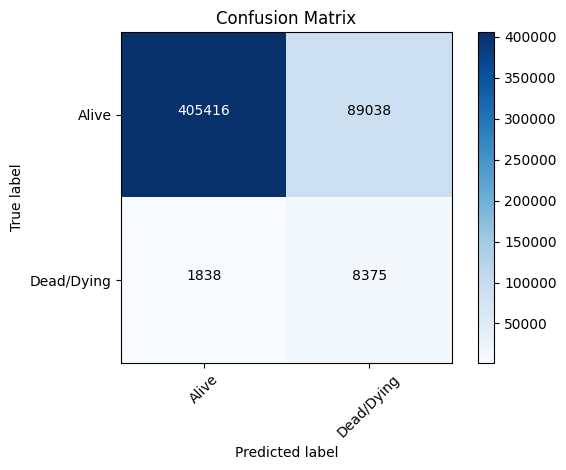

In [19]:
 #plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, (y_test_pred > 0.5))
f1 = f1_score(y_test, (y_test_pred > 0.5))

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix
cm = confusion_matrix(y_test, (y_test_pred > 0.5))

# Plot the confusion matrix
class_names = ['Alive', 'Dead/Dying'] # positive class should come the last
plot_confusion_matrix(cm, class_names)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

y = df[main_label].values
X = df.drop([main_label], axis=1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

tfidf_vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_tfidf, y_train)

y_pred = dt_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

classification_report_str = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report_str)

ValueError: ignored

In [40]:
X_train_tfidf

<8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [22]:
# training a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)

# accuracy on X_test
accuracy = gnb.score(X_test, y_test)
print(accuracy)

# creating a confusion matrix
cm = confusion_matrix(y_test, gnb_predictions)
print(cm)

target_names = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8']
print(classification_report(y_test, gnb_predictions, target_names=target_names))

ValueError: ignored

# **Explanation with SHAP Values**

Average dead/dying tree probability is 0.0202


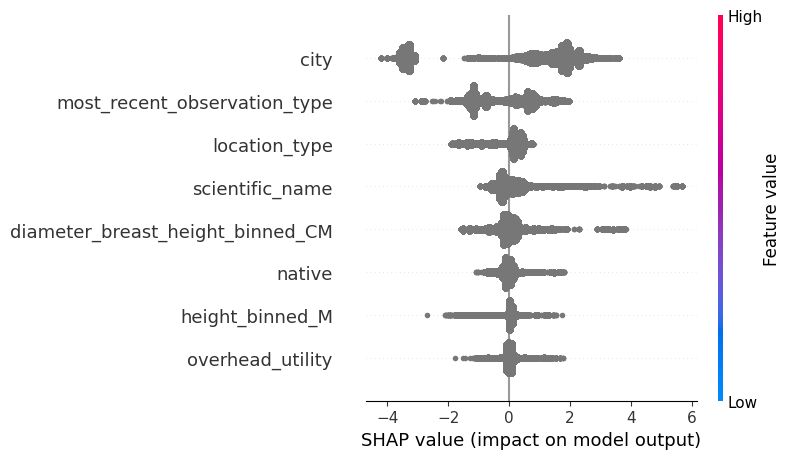

CPU times: user 1min 29s, sys: 2.43 s, total: 1min 31s
Wall time: 1min 13s


In [ ]:
%%time
shap.initjs()
ex = shap.TreeExplainer(model)
print(f"Average dead/dying tree probability is {round(np.mean(y_test),4)}")
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

***Explain Data !!!!!***

# **Explanation with ELI5**

In [ ]:
eli5.explain_weights(model)

Weight,Feature
0.3809,city
0.1511,most_recent_observation_type
0.1123,diameter_breast_height_binned_CM
0.1117,location_type
0.0991,scientific_name
0.0892,native
0.0295,height_binned_M
0.0263,overhead_utility


# **.**

In [ ]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline

In [ ]:
X_test.shape

(504667, 8)

In [ ]:
y_train.shape

(2018667,)

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["Alive", "Dead/Dying"])

def my_predict_function(x):

    testing_sequences = tokenizer.texts_to_sequences(x)
    testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    pred = model.predict(testing_padded)

    format_pred = np.concatenate([1.0-pred, pred], axis=1)

    return format_pred

exp = explainer.explain_instance("movie is bad", my_predict_function, num_features=7)

print(exp.as_list())

NameError: ignored

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
X_train_counts

<9x9 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_tfidf

<9x9 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)
X_test_counts = count_vect.transform(y)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pred = classifier.predict(X_test_tfidf)
print(f"Accuracy Score: {accuracy_score(X_test, y_pred)}")

ValueError: ignored